## <font color='purple'> Data 255 - Lab 1 - Part 3 - Custom Model

<font color='purple'> Part 3: Object Detection
Download Road Sign Dataset from the following link:
https://drive.google.com/drive/folders/1yvzEtFDqodCUIssXIKMrQ_YtL_0gNHyA
 
<font color='purple'> 7. Perform necessary data transformation and augmentation steps (1 point) \
<font color='purple'>8. Plot some random images from the train, test, and validation set. (2 points) \
<font color='purple'>9. Pick one model of your choice and implement it from scratch to perform object
detection. \
<font color='purple'>10. Compute the IOU of your results with the test set and print a few predicted images.

<font color='blue'> I have used Kaggle for my training and validations using available GPU. Loaded the dataset from Google Drive onto my Kaggle account for this use case

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import yaml
import time
import random
from PIL import Image
import xml.etree.ElementTree as ET
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import RoIPool, RoIAlign
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, OneCycleLR, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report
# import albumentations as A

<font color='blue'> Cleanup the Kaggle Working directory before proceeding to avoid overlapping with other results from previous runs

In [2]:
!rm -rf /kaggle/working/*

<font color='blue'> Parse the YAML file and print the unique classes

In [3]:
with open('/kaggle/input/data.yaml', 'r') as f:
    data = yaml.safe_load(f)
    classes = data['names']
print("Number of classes:", len(classes))
print("Classes:", classes)

Number of classes: 25
Classes: ['-Road narrows on right', 'Attention Please-', 'Beware of children', 'CYCLE ROUTE AHEAD WARNING', 'Crosswalk', 'Dangerous Left Curve Ahead', 'Dangerous Rright Curve Ahead', 'No Entry', 'No_Over_Taking', 'One way road', 'Speed bump ahead', 'Speed limit', 'Speed limit 100 Kph', 'Speed limit 120 Kph', 'Speed limit 20 Kph', 'Speed limit 30 Kph', 'Speed limit 40 Kph', 'Speed limit 50 Kph', 'Speed limit 60 Kph', 'Speed limit 70 Kph', 'Speed limit 80 Kph', 'Speed limit 90 Kph', 'Stop_Sign', 'Uneven Road', 'roundabout']


<font color='blue'> Create the dataset class, this will be used to create dataloaders for training our model

In [4]:
def create_dataset(img_dir, label_dir, transform=None):
    class RoadSignDataset(Dataset):
        def __init__(self, img_dir, label_dir, transform=None):
            self.img_dir = img_dir
            self.label_dir = label_dir
            self.transform = transform
            self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')]
        
        def __len__(self):
            return len(self.img_files)
        
        def __getitem__(self, idx):
            img_path = os.path.join(self.img_dir, self.img_files[idx])
            label_path = os.path.join(self.label_dir, self.img_files[idx].replace('.jpg', '.xml').replace('.png', '.xml'))
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            
            tree = ET.parse(label_path)
            root = tree.getroot()
            boxes = []
            class_labels = []
            for obj in root.findall('object'):
                name = obj.find('name').text
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)
                width = int(root.find('size/width').text)
                height = int(root.find('size/height').text)
                x_center = (xmin + xmax) / (2 * width)
                y_center = (ymin + ymax) / (2 * height)
                w = (xmax - xmin) / width
                h = (ymax - ymin) / height
                boxes.append([x_center, y_center, w, h])
                class_labels.append(classes.index(name))
            return image, torch.tensor(boxes), torch.tensor(class_labels), len(boxes), self.img_files[idx]
    return RoadSignDataset(img_dir, label_dir, transform)

<font color='blue'> Create the Custom Backbone for Fast RCNN model. Adding Convolutional Layers and Residual Blocks to create a custom ResNet Backbone. We have also added Batch normalization along with ReLU initialization. Dropout layers have also been added to prevent overfitting.

In [5]:
def create_custom_backbone():
    class ConvBlock(nn.Module):
        def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            super(ConvBlock, self).__init__()
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
            self.bn = nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU(inplace=True)
            
        def forward(self, x):
            return self.relu(self.bn(self.conv(x)))

    class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride=1):
            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU(inplace=True)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.bn2 = nn.BatchNorm2d(out_channels)
            
            self.shortcut = nn.Sequential()
            if stride != 1 or in_channels != out_channels:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(out_channels)
                )
                
        def forward(self, x):
            residual = x
            
            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)
            
            out = self.conv2(out)
            out = self.bn2(out)
            
            out += self.shortcut(residual)
            out = self.relu(out)
            
            return out
        
    class CustomBackbone(nn.Module):
        def __init__(self):
            super(CustomBackbone, self).__init__()
            
            self.initial = nn.Sequential(
                ConvBlock(3, 16, kernel_size=7, stride=2, padding=3),
                nn.BatchNorm2d(16), nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )
            
            self.layer1 = nn.Sequential(
                ResidualBlock(16, 16),
                ResidualBlock(16, 16)
            )
            
            self.layer2 = nn.Sequential(
                ResidualBlock(16, 32, stride=2),
                ResidualBlock(32, 32)
            )
            
            self.layer3 = nn.Sequential(
                ResidualBlock(32, 64, stride=2),
                ResidualBlock(64, 64)
            )
            
            self.layer4 = nn.Sequential(
                ResidualBlock(64, 128, stride=2),
                ResidualBlock(128, 128)
            )
            
            self.layer5 = nn.Sequential(
                ResidualBlock(128, 256, stride=2),
                ResidualBlock(256, 256),
                nn.Dropout(0.2)
            )
            
            self.layer6 = nn.Sequential(
                ResidualBlock(256, 512, stride=2),
                ResidualBlock(512, 512),
                ResidualBlock(512, 512)
            )
            
        def forward(self, x):
            x = self.initial(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.layer5(x)
            x = self.layer6(x)
            return x
            
    return CustomBackbone()

<font color='blue'> Create a custom FastRCNN model class. This will be our baseline model architecture.

In [6]:
def create_fast_rcnn_model(num_classes):
    class FastRCNN(nn.Module):
        def __init__(self, num_classes):
            super(FastRCNN, self).__init__()
            self.backbone = create_custom_backbone()
            self.roi_pool = RoIAlign(output_size=(7, 7), spatial_scale=1/32, sampling_ratio=2)
            self.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(4096, 2048),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
            )
            self.cls_score = nn.Linear(2048, num_classes)
            self.bbox_pred = nn.Linear(2048, 4)

        def forward(self, x, rois):
            features = self.backbone(x)
            pooled_features = self.roi_pool(features, rois)
            flattened = pooled_features.view(pooled_features.size(0), -1)
            fc_features = self.classifier(flattened)
            cls_scores = self.cls_score(fc_features)
            bbox_preds = self.bbox_pred(fc_features)
            return cls_scores, bbox_preds
    return FastRCNN(num_classes)

<font color='blue'> Custom Collate function is used here to process images having multiple bounding boxes. The dataset has images with more than one objects and as a result, multiple bounding boxes. This helps to have consistent dimensions accross batches during training.

In [7]:
def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    boxes = [item[1] for item in batch]
    labels = [item[2] for item in batch]
    num_boxes = [item[3] for item in batch]
    img_names = [item[4] for item in batch]
    images = torch.stack(images, 0)
    max_num_boxes = max(num_boxes)
    if max_num_boxes > 0:
        padded_boxes = torch.zeros(len(batch), max_num_boxes, 4)
        padded_labels = torch.full((len(batch), max_num_boxes), -1, dtype=torch.long)
        for i, (box, label, num) in enumerate(zip(boxes, labels, num_boxes)):
            if num > 0:
                padded_boxes[i, :num] = box
                padded_labels[i, :num] = label
    else:
        padded_boxes = torch.zeros(len(batch), 1, 4)
        padded_labels = torch.full((len(batch), 1), -1, dtype=torch.long)
    return images, padded_boxes, padded_labels, torch.tensor(num_boxes), img_names

<font color='blue'> Function to create Dataloaders for training

In [8]:
def create_data_loader(dataset, batch_size, num_workers, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=custom_collate_fn, num_workers=num_workers)

<font color='blue'> Validate model function

In [9]:
def validate_model(model, val_loader, cls_criterion, bbox_criterion, device):
    model.eval()
    total_loss = 0
    correct_cls = 0
    total_cls = 0
    with torch.no_grad():
        for images, boxes, labels, num_boxes, _ in val_loader:
            images = images.to(device)
            boxes = boxes.to(device)
            labels = labels.to(device)
            num_boxes = num_boxes.to(device)
            batch_size = images.size(0)
            rois = []
            all_labels = []
            all_boxes = []
            
            for i in range(batch_size):
                if num_boxes[i] > 0:
                    valid_boxes = boxes[i, :num_boxes[i]]
                    valid_labels = labels[i, :num_boxes[i]]
                    img_rois = torch.cat([torch.full((valid_boxes.size(0), 1), i, device=device), valid_boxes], dim=1)
                    rois.append(img_rois)
                    all_labels.append(valid_labels)
                    all_boxes.append(valid_boxes)
                    
            if not rois:
                continue
                
            rois = torch.cat(rois, dim=0)
            all_labels = torch.cat(all_labels)
            all_boxes = torch.cat(all_boxes)
            
            cls_scores, bbox_preds = model(images, rois)
            
            cls_loss = cls_criterion(cls_scores, all_labels)
            bbox_loss = bbox_criterion(bbox_preds, all_boxes)
            loss = cls_loss + bbox_loss
            total_loss += loss.item()
            
            _, predicted_cls = torch.max(cls_scores, 1)
            correct_cls += (predicted_cls == all_labels).sum().item()
            total_cls += all_labels.size(0)
    
    avg_loss = total_loss / len(val_loader)
    val_accuracy = correct_cls / total_cls if total_cls > 0 else 0
    
    return avg_loss, val_accuracy

<font color='blue'> Train Model Function

In [10]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, cls_criterion, bbox_criterion, num_epochs, patience, device):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_loss, correct_cls, total_cls = 0, 0, 0
        
        for images, boxes, labels, num_boxes, _ in train_loader:
            images = images.to(device)
            boxes = boxes.to(device)
            labels = labels.to(device)
            num_boxes = num_boxes.to(device)
            batch_size = images.size(0)
            rois = []
            all_labels = []
            all_boxes = []
            
            for i in range(batch_size):
                if num_boxes[i] > 0:
                    valid_boxes = boxes[i, :num_boxes[i]]
                    valid_labels = labels[i, :num_boxes[i]]
                    img_rois = torch.cat([torch.full((valid_boxes.size(0), 1), i, device=device), valid_boxes], dim=1)
                    rois.append(img_rois)
                    all_labels.append(valid_labels)
                    all_boxes.append(valid_boxes)
                    
            if not rois:
                continue
                
            rois = torch.cat(rois, dim=0)
            all_labels = torch.cat(all_labels)
            all_boxes = torch.cat(all_boxes)
            optimizer.zero_grad()
            cls_scores, bbox_preds = model(images, rois)
            
            # print(f"cls_scores shape: {cls_scores.shape}, all_labels shape: {all_labels.shape}")
            
            # Use Focal Loss instead of CrossEntropyLoss
            cls_loss = cls_criterion(cls_scores, all_labels)
            bbox_loss = bbox_criterion(bbox_preds, all_boxes)
            loss = cls_loss + bbox_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            # scheduler.step()
            total_loss += loss.item()
            
            _, preds = torch.max(cls_scores, 1) 
            correct_cls += (preds == all_labels).sum().item() 
            total_cls += all_labels.size(0) 
            
        train_loss = total_loss / len(train_loader)
        train_accuracy = correct_cls / total_cls if total_cls > 0 else 0
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        val_loss, val_accuracy = validate_model(model, val_loader, cls_criterion, bbox_criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        end_time = time.time()
        epoch_time = end_time - start_time 
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}, "
              f"Time Taken: {epoch_time:.2f} seconds")
        
        # scheduler.step()
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0 
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs without improvement.")
            break
    
    plt.figure(figsize=(15, 5)) 

    ax1 = plt.subplot(1, 2, 1) 
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='orange')
    ax1.set_title('Training and Validation Loss vs. Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()

    ax2 = plt.subplot(1, 2, 2) 
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='orange')
    ax2.set_title('Training and Validation Accuracy vs. Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()
    
    return model

<font color='blue'> Function to Plot Random Images from the dataset

In [11]:
def plot_random_images(dataset, num_images=5):
    
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    inv_normalize = transforms.Compose([
        transforms.Normalize(mean=[0., 0., 0.],
                             std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                             std=[1., 1., 1.]),
    ])
    
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        image, boxes, labels, _, _ = dataset[idx]
        image = inv_normalize(image)
        image_np = image.permute(1, 2, 0).numpy()
        image_np = np.clip(image_np, 0, 1)
        axes[i].imshow(image_np)
        
        for box, label in zip(boxes, labels):
            x_center, y_center, w, h = box
            x = (x_center - w/2) * 224
            y = (y_center - h/2) * 224
            width = w * 224
            height = h * 224
            rect = plt.Rectangle((x, y), width, height, fill=False, edgecolor='r', linewidth=2)
            axes[i].add_patch(rect)
            axes[i].text(x, y-5, classes[label], color='r', fontsize=8,
                         bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

<font color='blue'> Transform Dataset Wrapper. This is used to apply different transformations to train, val and test datasets

In [12]:
class TransformDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        # Unpacking the four returned values
        image, boxes, class_labels, num_boxes, img_names = self.dataset[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, boxes, class_labels, num_boxes, img_names

<font color='blue'> Setup the Image Directories, Transformations and primary Dataset. Also perform an 80/20 Split for Train and Validate sets using the raw train dataset.

In [13]:
train_img_dir = '/kaggle/input/Archive/train/images'
train_label_dir = '/kaggle/input/Archive/labels_train'
test_img_dir = '/kaggle/input/Archive/test/images'
test_label_dir = '/kaggle/input/Archive/labels_test'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset_full = create_dataset(train_img_dir, train_label_dir, transform=None)
test_dataset = create_dataset(test_img_dir, test_label_dir, transform=test_transforms)
train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset_raw, val_dataset_raw = torch.utils.data.random_split(train_dataset_full, [train_size, val_size])

train_dataset = TransformDataset(train_dataset_raw, transform=train_transforms)
val_dataset = TransformDataset(val_dataset_raw, transform=val_transforms)

<font color='blue'> Plot the distribution for class labels to see if there is Class Imbalance.

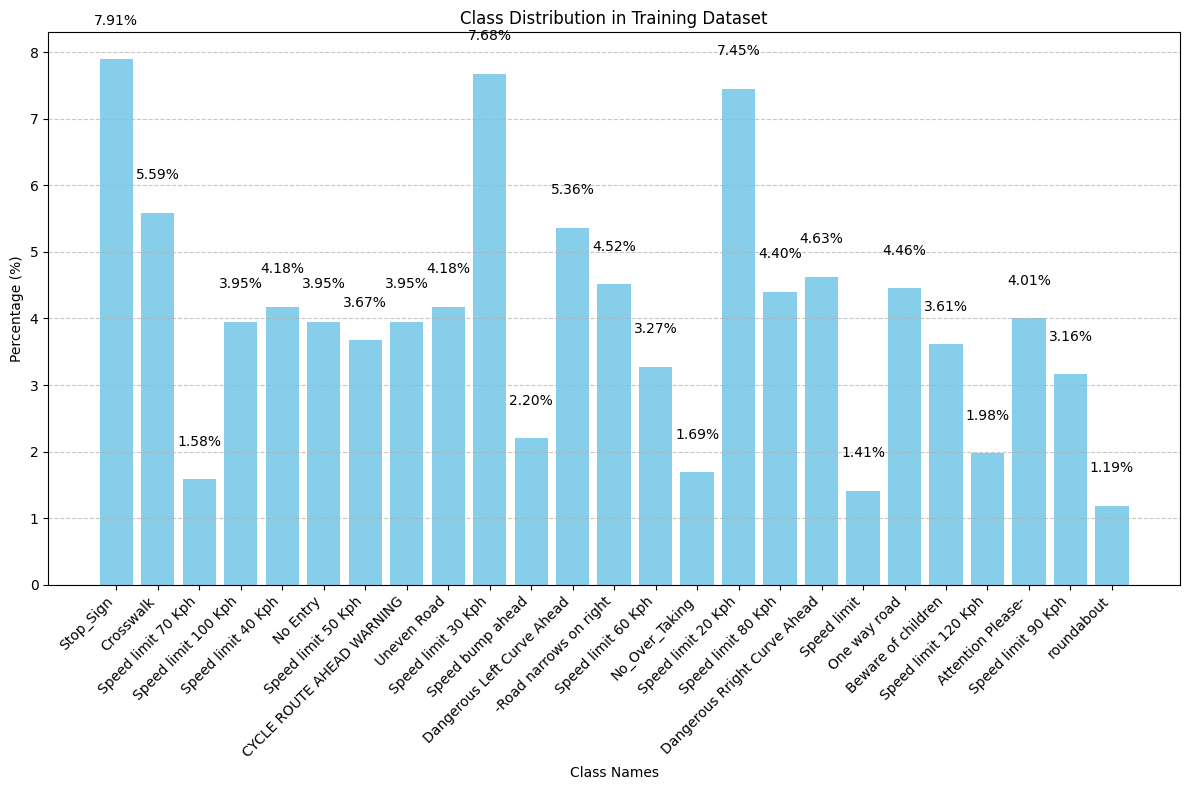

In [14]:
class_counts = Counter()

for i in range(len(train_dataset_full)):
    image, bbox, label_tensor, _, _ = train_dataset_full[i]

    if label_tensor.numel() == 0:
        continue

    if label_tensor.dim() > 1:
        label = label_tensor[0, 0].item()
    else:
        label = label_tensor[0].item()

    class_counts[label] += 1

total_samples = sum(class_counts.values())

labels = list(class_counts.keys())
counts = [class_counts[label] for label in labels]
percentages = [(count / total_samples) * 100 for count in counts]

plt.figure(figsize=(12, 8))
plt.bar(np.array(classes)[labels], percentages, color='skyblue')
plt.xlabel('Class Names')
plt.ylabel('Percentage (%)')
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(percentages):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center')

plt.tight_layout()
plt.show()

<font color='blue'> Plot some random images from all three datasets train, test and validate

Random images from train dataset:


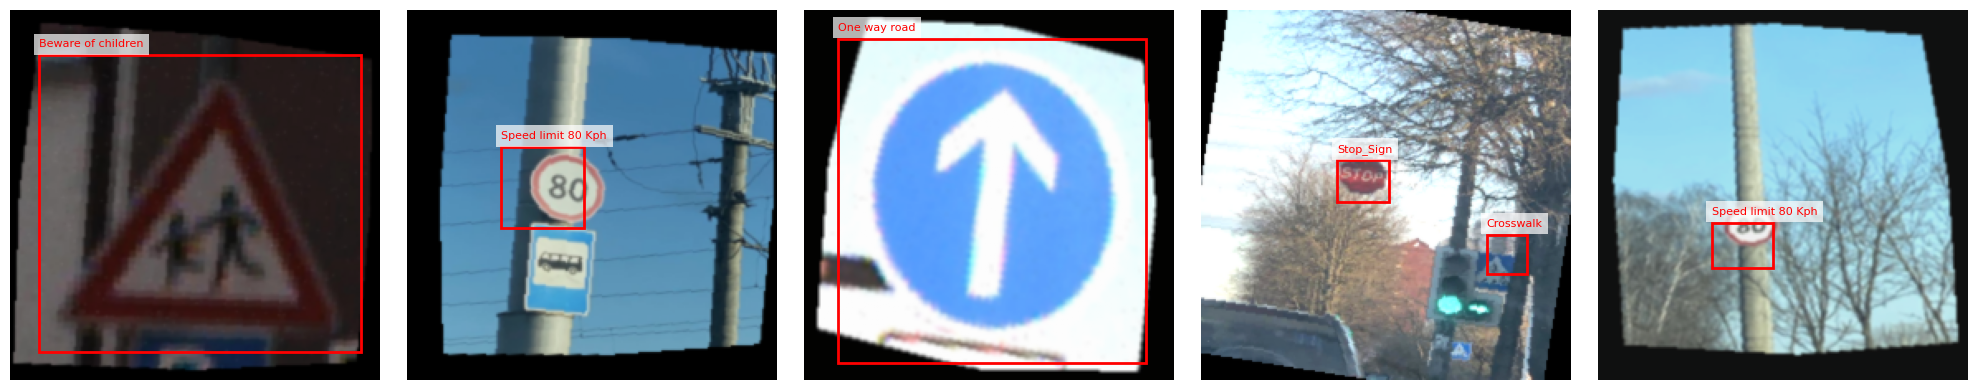

Random images from Val dataset:


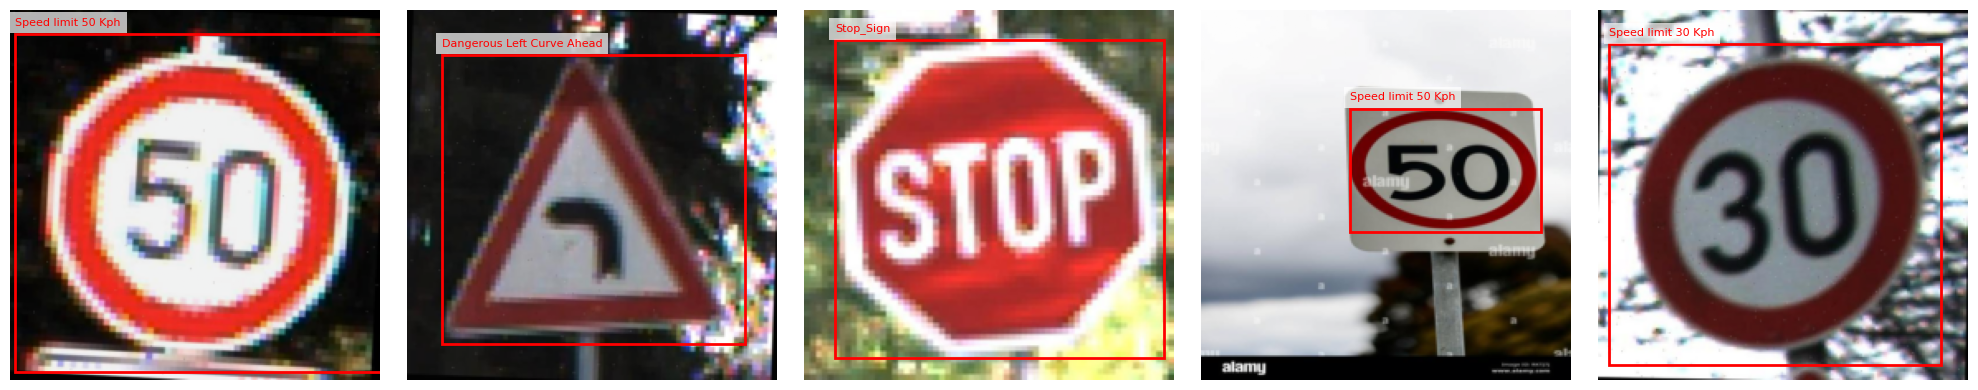

Random images from test dataset:


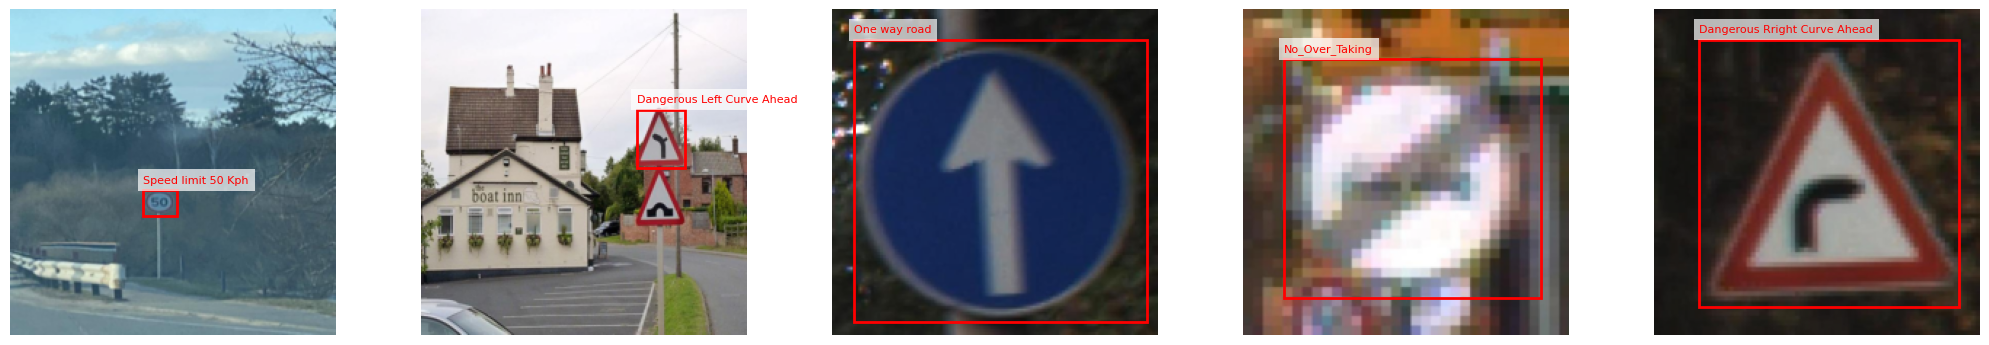

In [15]:
print("Random images from train dataset:")
print("==================================")
plot_random_images(train_dataset)

print("Random images from Val dataset:")
print("==================================")
plot_random_images(val_dataset)

print("Random images from test dataset:")
print("==================================")
plot_random_images(test_dataset)

<font color='blue'> Create Dataloaders with 64 Batch size

In [16]:
train_loader = create_data_loader(train_dataset, batch_size=64, num_workers=4, shuffle=True)
test_loader = create_data_loader(test_dataset, batch_size=64, num_workers=4, shuffle=True)
val_loader = create_data_loader(val_dataset, batch_size=64, num_workers=4, shuffle=False)

<font color='blue'> Print the size of the dataloaders

In [17]:
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of samples in train dataset: {len(train_loader.dataset)}")

print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of samples in val dataset: {len(val_loader.dataset)}")

print(f"Number of batches in test_loader: {len(test_loader)}")
print(f"Number of samples in test dataset: {len(test_loader.dataset)}")

Number of batches in train_loader: 67
Number of samples in train dataset: 4260
Number of batches in val_loader: 17
Number of samples in val dataset: 1065
Number of batches in test_loader: 10
Number of samples in test dataset: 623


<font color='blue'> Setup the device for using CUDA to train on GPUs

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


<font color='blue'> Setup custom function for Focal Loss

In [19]:
'''class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)  # Probability of correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()'''
    
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

<font color='blue'> Setup the training Parameters and intiate training

<font color='blue'> Experimented with different loss functions, optimizers and schedulers.  However, the most stable performance was achieved with FocalLoss function, AdamW optimizer and ReduceLROnPlateau scheduler. 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/150], Train Loss: 2.5539, Train Accuracy: 0.0605, Val Loss: 0.8036, Validation Accuracy: 0.0873, Time Taken: 39.27 seconds
Epoch [2/150], Train Loss: 0.8058, Train Accuracy: 0.0754, Val Loss: 0.7701, Validation Accuracy: 0.0888, Time Taken: 46.32 seconds
Epoch [3/150], Train Loss: 0.7258, Train Accuracy: 0.1037, Val Loss: 0.6306, Validation Accuracy: 0.1418, Time Taken: 35.81 seconds
Epoch [4/150], Train Loss: 0.6636, Train Accuracy: 0.1284, Val Loss: 0.6054, Validation Accuracy: 0.1478, Time Taken: 32.00 seconds
Epoch [5/150], Train Loss: 0.6159, Train Accuracy: 0.1627, Val Loss: 0.5379, Validation Accuracy: 0.1634, Time Taken: 31.56 seconds
Epoch [6/150], Train Loss: 0.5795, Train Accuracy: 0.1753, Val Loss: 0.5229, Validation Accuracy: 0.2254, Time Taken: 32.20 seconds
Epoch [7/150], Train Loss: 0.5428, Train Accuracy: 0.2106, Val Loss: 0.4814, Validation Accuracy: 0.2313, Time Taken: 32.50 seconds
Epoch [8/150], Train Loss: 0.5175, Train Accuracy: 0.2303, Val Loss: 0.4597,

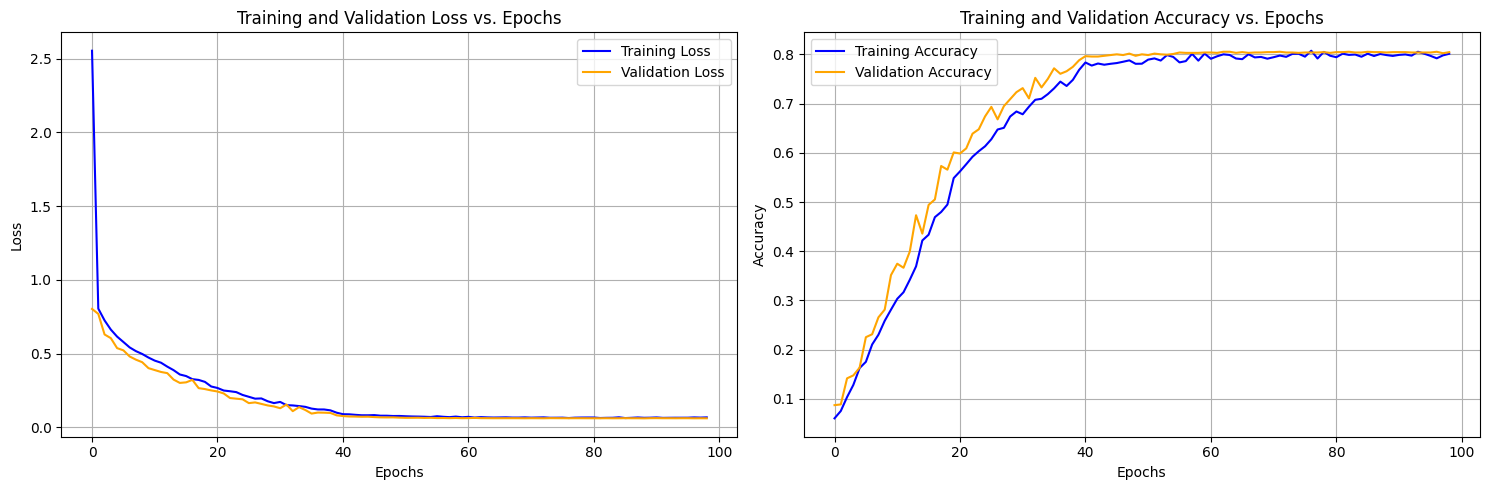

FastRCNN(
  (backbone): CustomBackbone(
    (initial): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1

In [20]:
num_classes = len(classes)
num_epochs = 150
model = create_fast_rcnn_model(num_classes).to(device)

# cls_criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
cls_criterion = FocalLoss(gamma=2.0)
bbox_criterion = nn.SmoothL1Loss(beta=0.5)

# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.0005,
    betas=(0.9, 0.999),
    weight_decay=0.01,
    eps=1e-8,
    amsgrad=True
)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
# scheduler = CosineAnnealingLR(optimizer, T_max=50)
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.00001)
'''scheduler = OneCycleLR(
    optimizer,
    max_lr=0.001,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos',
    cycle_momentum=True,
    base_momentum=0.85,
    max_momentum=0.95,
    div_factor=25.0,
    final_div_factor=1000.0
)'''

train_model(model, train_loader, val_loader, optimizer, scheduler, cls_criterion, bbox_criterion, num_epochs=num_epochs, patience=10, device=device)

<font color='blue'> Function to Calculate IOU

In [21]:
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    return intersection / union if union > 0 else 0

<font color='blue'> Function for Prediction on Test dataset

In [22]:
def predict(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    all_boxes = []
    all_true_boxes = []
    all_image_names = []
    
    with torch.no_grad():
        for images, boxes, labels, num_boxes, img_names in data_loader:
            images = images.to(device)
            boxes = boxes.to(device)
            batch_size = images.size(0)
            rois = []
            batch_labels = []
            batch_true_boxes = []
            
            for i in range(batch_size):
                if num_boxes[i] > 0:
                    valid_boxes = boxes[i, :num_boxes[i]]
                    img_rois = torch.cat([torch.full((valid_boxes.size(0), 1), i, device=device), valid_boxes], dim=1)
                    rois.append(img_rois)
                    batch_labels.extend(labels[i, :num_boxes[i]].cpu().numpy())
                    batch_true_boxes.extend(valid_boxes.cpu().numpy())
                else:
                    dummy_roi = torch.tensor([[i, 0, 0, 1, 1]], device=device)
                    rois.append(dummy_roi)
                    batch_labels.append(-1)
                    batch_true_boxes.append(np.array([0, 0, 1, 1]))
                    
            rois = torch.cat(rois, dim=0)
            cls_scores, bbox_preds = model(images, rois)
            _, predicted_classes = torch.max(cls_scores, 1)
            all_predictions.extend(predicted_classes.cpu().numpy())
            all_labels.extend(batch_labels)
            all_boxes.extend(bbox_preds.cpu().numpy())
            all_true_boxes.extend(batch_true_boxes)
            all_image_names.extend(img_names)
            
    return np.array(all_predictions), np.array(all_labels), np.array(all_boxes), np.array(all_true_boxes), all_image_names

<font color='blue'> Function to Evaluate Predictions

In [23]:
def evaluate_predictions(predictions, true_labels, pred_boxes, true_boxes):
    
    min_length = min(len(predictions), len(true_labels), len(pred_boxes), len(true_boxes))
    predictions = predictions[:min_length]
    true_labels = true_labels[:min_length]
    pred_boxes = pred_boxes[:min_length]
    true_boxes = true_boxes[:min_length]
    
    
    valid_indices = true_labels != -1
    valid_predictions = predictions[valid_indices]
    valid_true_labels = true_labels[valid_indices]
    valid_pred_boxes = pred_boxes[valid_indices]
    valid_true_boxes = true_boxes[valid_indices]
    accuracy = accuracy_score(valid_true_labels, valid_predictions)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(valid_true_labels, valid_predictions, target_names=classes))
    
    
    ious = []
    for pred_box, true_box in zip(valid_pred_boxes, valid_true_boxes):
        iou = calculate_iou(pred_box, true_box)
        ious.append(iou)
    mean_iou = np.mean(ious)
    
    print(f"\nMean IoU: {mean_iou:.4f}")

<font color='blue'> Run the prediction on test dataset using the trained model and evaluate metrics.

In [24]:
predictions, true_labels, pred_boxes, true_boxes, all_image_names = predict(model, test_loader, device)
evaluate_predictions(predictions, true_labels, pred_boxes, true_boxes)

Test Accuracy: 0.5518

Classification Report:
                              precision    recall  f1-score   support

      -Road narrows on right       0.86      0.80      0.83        15
           Attention Please-       0.95      0.87      0.91        23
          Beware of children       0.71      0.74      0.72        23
   CYCLE ROUTE AHEAD WARNING       0.87      0.90      0.88        29
                   Crosswalk       0.30      0.26      0.28        43
  Dangerous Left Curve Ahead       0.57      0.71      0.63        24
Dangerous Rright Curve Ahead       0.91      0.67      0.77        30
                    No Entry       0.71      0.74      0.73        27
              No_Over_Taking       0.76      0.83      0.79        23
                One way road       1.00      0.74      0.85        27
            Speed bump ahead       0.33      0.24      0.28        50
                 Speed limit       0.22      0.18      0.20        34
         Speed limit 100 Kph       0.45    

In [25]:
print("Length of all_image_names:", len(all_image_names))
print("Length of predictions:", len(predictions))
print("Length of true_labels:", len(true_labels))

Length of all_image_names: 623
Length of predictions: 802
Length of true_labels: 802


<font color='blue'> Save the Predictions in a CSV file with ground truth and predicted labels

In [26]:
class_names = classes
class_names = {i: name for i, name in enumerate(classes)}

expanded_results = []

for img_name in all_image_names:
    index = all_image_names.index(img_name)
    preds_for_img = predictions[index]
    true_labels_for_img = true_labels[index]
    
    if not isinstance(preds_for_img, list):
        preds_for_img = [preds_for_img]
        
    if not isinstance(true_labels_for_img, list):
        true_labels_for_img = [true_labels_for_img]
        
    for pred in preds_for_img:
        for true_label in true_labels_for_img:
            expanded_results.append({
                'Image_Name': img_name,
                'Predicted_Class': pred,
                'True_Class': true_label
            })

predictions_df = pd.DataFrame(expanded_results)

predictions_df['Predicted_Class'] = predictions_df['Predicted_Class'].map(class_names)
predictions_df['True_Class'] = predictions_df['True_Class'].map(class_names)

predictions_df.to_csv('final_predictions.csv', index=False)

<font color='blue'> Plot random Images from the test dataset with predicted labels and bounding boxes

In [29]:
def visualize_predictions(model, test_dataset, num_images=20):
    fig, axes = plt.subplots(10, 4, figsize=(10, 30))
    model.eval()
    
    with torch.no_grad():
        for i in range(10):
            for j in range(4):
                idx = random.randint(0, len(test_dataset) - 1)
                image, boxes, labels, num_boxes, _ = test_dataset[idx]
                image = image.unsqueeze(0).to(device)
                boxes = boxes.to(device)
                
                if num_boxes > 0:
                    rois = torch.cat([torch.zeros(num_boxes, 1).to(device), boxes[:num_boxes]], dim=1)
                else:
                    rois = torch.tensor([[0, 0, 0, 1, 1]], device=device)
                    
                cls_scores, _ = model(image, rois)
                _, predicted_classes = torch.max(cls_scores, 1)
                
                
                img_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
                img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
                axes[i, j].imshow(img_np)
                
                if num_boxes > 0:
                    for k, (box, label, pred) in enumerate(zip(boxes[:num_boxes], labels[:num_boxes], predicted_classes)):
                        x, y, w, h = box.cpu().numpy()
                        rect = plt.Rectangle((x*224, y*224), w*224, h*224, fill=False, edgecolor='r', linewidth=2)
                        axes[i, j].add_patch(rect)
                        axes[i, j].text(x*224, y*224-5, f"T: {classes[label]}\nP: {classes[pred]}",
                                        color='r', fontsize=6, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
                else:
                    axes[i, j].text(10, 10, "No valid bounding boxes", color='r', fontsize=10)
                
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

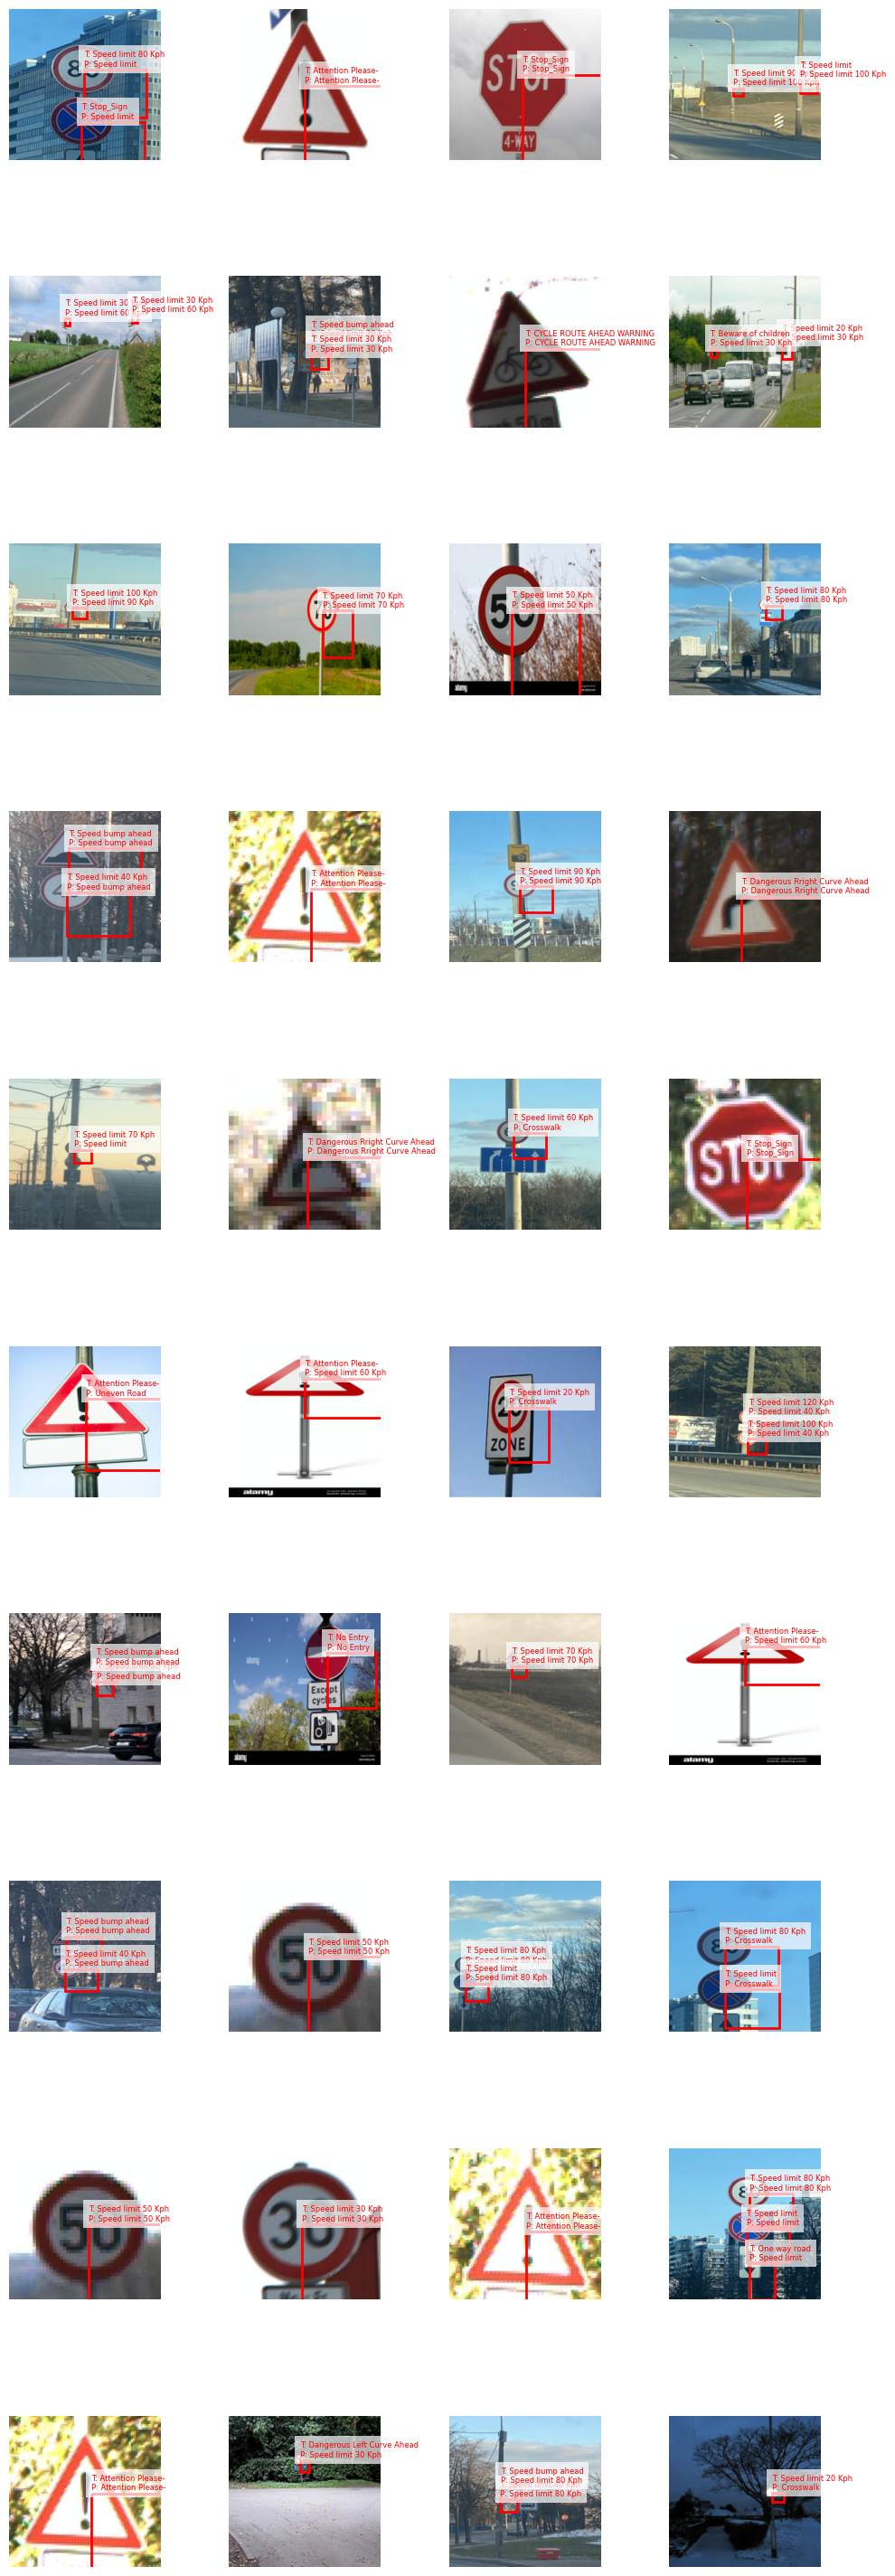

In [30]:
visualize_predictions(model, test_dataset, num_images=40)

<font color='blue'> Save the model State

In [31]:
torch.save(model.state_dict(), "RCNN_model_state.pth")

<font color='blue'> Generate Image annotations in Yolo format using the predictions

In [41]:
n = 5
print("All Image Names:")
for i, img_name in enumerate(all_image_names[:n]):
    print(f"{i+1}: {img_name}")

print("\nPredictions (Class IDs):")
for i, pred in enumerate(predictions[:n]):
    print(f"{i+1}: {pred}")

print("\nPrediction Boxes (Bounding Box Coordinates):")
for i, box in enumerate(pred_boxes[:n]):
    print(f"{i+1}: {box}")

print("\nLengths of Variables:")
print(f"all_image_names: {len(all_image_names)}")
print(f"predictions: {len(predictions)}")
print(f"pred_boxes: {len(pred_boxes)}")

All Image Names:
1: 00041_00000_00010_png_jpg.rf.92d228ecd147bfe05fcd5e6d0c2ef7c8.jpg
2: road357_png.rf.accfb6715c5191d4bca4eb62f68d6f38.jpg
3: road737_png.rf.a6d4e3aa97d1d1c3851252a541f82b11.jpg
4: road383_png.rf.07ecd0781ba5335ad28373b41073f1be.jpg
5: 00035_00014_00023_png_jpg.rf.7af786f45826741b582f6c5b0a4a0926.jpg

Predictions (Class IDs):
1: 8
2: 22
3: 12
4: 12
5: 11

Prediction Boxes (Bounding Box Coordinates):
1: [0.51025105 0.49308917 0.8544521  0.8190535 ]
2: [0.42704022 0.40227368 0.27923748 0.25214082]
3: [0.4665054  0.48291138 0.1688272  0.13924786]
4: [0.4659466  0.48216555 0.16963498 0.14012676]
5: [0.45022973 0.45078754 0.23155302 0.20468935]

Lengths of Variables:
all_image_names: 623
predictions: 802
pred_boxes: 802


In [46]:
output_dir = "RCNN_final_preds"
os.makedirs(output_dir, exist_ok=True)

image_predictions = {}

for i, img_name in enumerate(all_image_names):
    if img_name not in image_predictions:
        image_predictions[img_name] = {'classes': [], 'boxes': []}
    
    image_predictions[img_name]['classes'].append(predictions[i])
    image_predictions[img_name]['boxes'].append(pred_boxes[i])

def normalize_box(box):
    x_center, y_center, width, height = box
    return x_center, y_center, width, height

for img_name, data in image_predictions.items():
    txt_filename = os.path.join(output_dir, f"{img_name.replace('.jpg', '.txt')}")
    
    with open(txt_filename, 'w') as file:
        for class_id, box in zip(data['classes'], data['boxes']):
            x_center, y_center, width, height = normalize_box(box)
            file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

print("Prediction files in Yolo format have been saved to the 'RCNN_final_preds' directory")

Prediction files in Yolo format have been saved to the 'RCNN_final_preds' directory


<font color='blue'> Zip the predictions for easy download

In [47]:
!zip -r working_dir.zip /kaggle/working/RCNN_final_preds

  adding: kaggle/working/RCNN_final_preds/ (stored 0%)
  adding: kaggle/working/RCNN_final_preds/road635_png.rf.e3bdb125f1335a6ef979746d2bbcdbf6.txt (deflated 10%)
  adding: kaggle/working/RCNN_final_preds/00028_00006_00022_png_jpg.rf.06b7349799138a21d19366de497a30d4.txt (deflated 10%)
  adding: kaggle/working/RCNN_final_preds/UK_Bend_To_Left_Ahead_Sign_-_geograph-org-uk_-_5211362_jpg.rf.8becb1088dba72dc3576167e54358c0b.txt (deflated 11%)
  adding: kaggle/working/RCNN_final_preds/road481_png.rf.8b4354c5df03bcc91e297375a242130d.txt (deflated 13%)
  adding: kaggle/working/RCNN_final_preds/road727_png.rf.013c316d9fc19665aef6c7a599b777b5.txt (deflated 13%)
  adding: kaggle/working/RCNN_final_preds/00028_00007_00024_png_jpg.rf.81fcb320ec1b2f68d45ee898200dedde.txt (deflated 13%)
  adding: kaggle/working/RCNN_final_preds/road484_png.rf.ebf85e48e5cc22f43bc8fd2b30b40357.txt (deflated 13%)
  adding: kaggle/working/RCNN_final_preds/road227_png.rf.7bd8bf0df64b6ed3180341e08e2f8f68.txt (deflated 8%)

## <font color='purple'> Thank You